In [1]:
#Se importan las liobrerias necesarias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
from datetime import datetime
import warnings
import requests
import os
import csv
import json
warnings.filterwarnings('ignore')

In [2]:
# Se procesa la data de la respuesta de la API de OpenAI para obtener los mensajes a partir de los threads y se guarda en un archivo CSV
def procesar_response_data(response_data):
    data = json.loads(response_data)
    mensajes_procesados = []
    for mensaje in data.get('data', []):
        id_mensaje = mensaje.get('id')
        fecha_creacion = mensaje.get('created_at')
        id_asistente = mensaje.get('assistant_id')
        rol = mensaje.get('role')
        # Reemplaza comillas dobles por dos comillas dobles y maneja los saltos de línea dentro del contenido
        contenido = ' '.join([content.get('text', {}).get('value', '').replace('"', '""') for content in mensaje.get('content', []) if content.get('type') == 'text'])
        # Prepara el contenido para manejar correctamente los saltos de línea
        contenido = contenido.replace('\n', ' ')
        mensajes_procesados.append([id_mensaje, fecha_creacion, id_asistente, rol, contenido])
    return mensajes_procesados

API_KEY = "API_KEY_AQUI"

thread_ids = []
with open("tbl-table_01HTNS36WJCYD1CZC1FZN4P5CM-6.csv", "r") as file:
    csv_reader = csv.reader(file)
    next(csv_reader)
    for row in csv_reader:
        thread_ids.append(row[3])

with open("data.csv", "w", newline='') as csvfile:
    writer = csv.writer(csvfile, quoting=csv.QUOTE_ALL)
    writer.writerow(['thread_id', 'response_data'])

    for thread_id in thread_ids:
        url = f"https://api.openai.com/v1/threads/{thread_id}/messages"
        headers = {"Authorization": f"Bearer {API_KEY}", "Content-Type": "application/json", "OpenAI-Beta": "assistants=v1"}
        response = requests.get(url, headers=headers)

        if response.status_code == 200:
            writer.writerow([thread_id, json.dumps(response.json())])
        else:
            print(f"Error: {response.status_code}, {response.text}")

with open("data.csv", "r") as csvfile, open("data_procesada.csv", "w", newline='') as newfile:
    reader = csv.DictReader(csvfile)
    writer = csv.writer(newfile, quoting=csv.QUOTE_ALL)
    writer.writerow(['thread_id', 'id_mensaje', 'fecha_creacion', 'id_asistente', 'rol', 'contenido'])

    for row in reader:
        thread_id = row['thread_id']
        response_data = row['response_data']
        mensajes_procesados = procesar_response_data(response_data)

        for mensaje in mensajes_procesados:
            writer.writerow([thread_id] + mensaje)

print("Proceso completado")


Proceso completado


In [3]:
#Se carga el dataset
processed_data = pd.read_csv('data_procesada.csv')
processed_data.shape


(102, 6)

In [4]:
#Se muestran las primeras 5 filas del dataset
processed_data.head()

,thread_id,id_mensaje,fecha_creacion,id_asistente,rol,contenido
0,thread_Nuq9E9qsAQZtSUA95NxzRH1v,msg_tfgELUAgbtozcEQgUECjIOgP,1712684785,asst_H2OaK20N1yfPeDCMLzartKhr,assistant,La fibromialgia es un síndrome caracterizado p...
1,thread_Nuq9E9qsAQZtSUA95NxzRH1v,msg_HdHvI2rMM4KD5sQS2NEn4IvV,1712684783,NaN,user,Háblame de la fibromialgia
2,thread_Nuq9E9qsAQZtSUA95NxzRH1v,msg_RXlF6LpyGOIWanK5yIPmEbK6,1712684728,asst_H2OaK20N1yfPeDCMLzartKhr,assistant,¡Buenos días! ¿En qué puedo ayudarte hoy?
3,thread_Nuq9E9qsAQZtSUA95NxzRH1v,msg_AWAyp1wfEKvqGATDQ30c9Wrn,1712684727,NaN,user,Buenos días
4,thread_JMaHC1M8uE0QfTsT4S4tCQo9,msg_lU6FhI2cnnnXNCpSwiUWfjaa,1717863250,asst_H2OaK20N1yfPeDCMLzartKhr,assistant,¡Hola! ¡Buen día! ¿En qué puedo ayudarte hoy? ...


DATOS DE USUARIO
Total de Usuarios: 13
Total de mensajes enviados: 51
Promedio de mensajes por usuario: 3.923076923076923
Mediana de mensajes por usuario: 3.0
Desviacion estandar de mensajes por usuario: 2.9000442083279365
Maximo de mensajes por usuario: 10


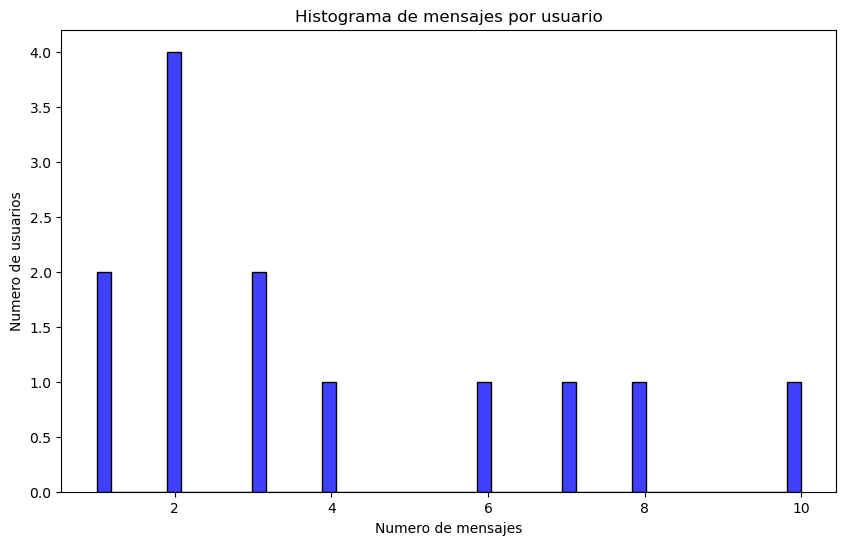

In [5]:
print('DATOS DE USUARIO')
# Numero de thread_id
total_thread_id = processed_data['thread_id'].nunique()
print('Total de Usuarios:', total_thread_id)
# Total de mensajes enviados por usuarios
total_user_interaccions = processed_data[processed_data['rol'] == 'user'].shape[0]
print('Total de mensajes enviados:', total_user_interaccions)
# Promedio de mensajes por usuario, se cuentan solo los rol user y se agrupan por thread_id
average_messages = processed_data[processed_data['rol'] == 'user'].groupby('thread_id').size().mean()
print('Promedio de mensajes por usuario:', average_messages)
# Se calcula la mediana de mensajes por usuario
median_messages = processed_data[processed_data['rol'] == 'user'].groupby('thread_id').size().median()
print('Mediana de mensajes por usuario:', median_messages)
#Se calcula la desviacion estandar de mensajes por usuario
std_messages = processed_data[processed_data['rol'] == 'user'].groupby('thread_id').size().std()
print('Desviacion estandar de mensajes por usuario:', std_messages)
#Se muestra el maximo de mensajes por usuario
max_messages = processed_data[processed_data['rol'] == 'user'].groupby('thread_id').size().max()
print('Maximo de mensajes por usuario:', max_messages)
# Se grafica el histograma de mensajes por usuario
plt.figure(figsize=(10, 6))
sns.histplot(processed_data[processed_data['rol'] == 'user'].groupby('thread_id').size(), bins=50, color='blue', stat='count')
plt.title('Histograma de mensajes por usuario')
plt.xlabel('Numero de mensajes')
plt.ylabel('Numero de usuarios')
plt.show()

DATOS DE ASSISTANT
Longitud promedio de mensajes de assistant: 87.33333333333333 palabras, 131.0 tokens
Longitud mediana de mensajes de assistant: 63.0 palabras, 94.5 tokens
Longitud máxima de mensajes de assistant: 330 palabras, 495.0 tokens
Longitud mínima de mensajes de assistant: 6 palabras, 9.0 tokens


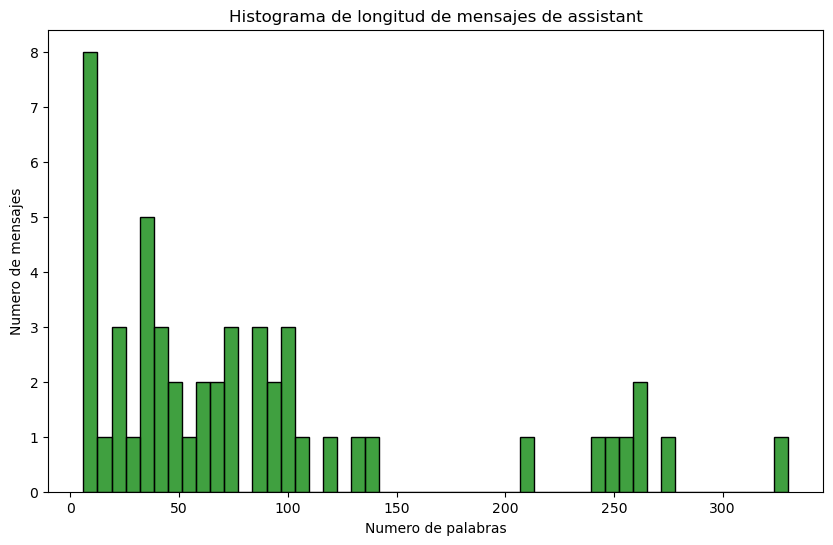

In [6]:
print('DATOS DE ASSISTANT')
token_factor = 1.5 # Estimacion de tokens por palabra superior (1.2 a 1.5 en español)
# Se calcula la longitud de los mensajes de assistant en palabras
processed_data['length'] = processed_data['contenido'].str.split().str.len()
# Se calcula la longitud promedio de los mensajes de assistant en palabras
average_length_assistant = processed_data[processed_data['rol'] == 'assistant']['length'].mean()
average_token = average_length_assistant * token_factor
print('Longitud promedio de mensajes de assistant:', average_length_assistant, 'palabras,', average_token, 'tokens')
# Se calcula la longitud mediana de los mensajes de assistant en palabras
median_length = processed_data[processed_data['rol'] == 'assistant']['length'].median()
median_token = median_length * token_factor
print('Longitud mediana de mensajes de assistant:', median_length, 'palabras,', median_token, 'tokens')
# Se calcula la longitud máxima de los mensajes de assistant en palabras
max_length = processed_data[processed_data['rol'] == 'assistant']['length'].max()
max_token = max_length * token_factor
print('Longitud máxima de mensajes de assistant:', max_length, 'palabras,', max_token, 'tokens')
# Se calcula la longitud mínima de los mensajes de assistant en palabras
min_length = processed_data[processed_data['rol'] == 'assistant']['length'].min()
min_token = min_length * token_factor
print('Longitud mínima de mensajes de assistant:', min_length, 'palabras,', min_token, 'tokens')

# Se grafica el histograma de longitud de mensajes de assistant
plt.figure(figsize=(10, 6))
sns.histplot(processed_data[processed_data['rol'] == 'assistant']['length'], bins=50, color='green', stat='count')
plt.title('Histograma de longitud de mensajes de assistant')
plt.xlabel('Numero de palabras')
plt.ylabel('Numero de mensajes')
plt.show()



In [7]:
print('VALORES DE USO')
# Coste por uso API GPT 3.5 0125 
input_token_value = 5.0e-7
output_token_value = 1.50e-6
token_aprox_per_input_with_retrieval = 2729 #Estimacion de tokens por mensaje de usuario, considera el retrieval del JSON requerido
# Se calcula el numero total de respuestas de assistant en palabras
total_length_assistant = processed_data[processed_data['rol'] == 'assistant']['length'].sum()

# Se calcula el numero total de tokens
total_token_user = total_user_interaccions * token_aprox_per_input_with_retrieval
total_token_assistant = total_length_assistant * token_factor

# Se calcula el coste
input_cost = total_token_user * input_token_value
output_cost = total_token_assistant * output_token_value
total_cost = input_cost + output_cost
cost_per_interaction = total_cost/total_thread_id
print('Coste total:', total_cost, 'USD')
print('Coste por interacción:', cost_per_interaction, 'USD')
print('Coste de Input / Total:', input_cost/total_cost)
# Se calcula el total de palabras de los mensajes de usuario
total_toke_only_user = processed_data[processed_data['rol'] == 'user']['length'].sum() * token_factor
# Se calcula el porcentaje de palabras de usuario respecto al total_length_user_retrieval
percentage_user = total_toke_only_user/total_token_user
print('Coste de Input Only User / User + Retrieval:', percentage_user)

VALORES DE USO
Coste total: 0.079611 USD
Coste por interacción: 0.006123923076923077 USD
Coste de Input / Total: 0.8741191543882126
Coste de Input Only User / User + Retrieval: 0.0021770525725863816


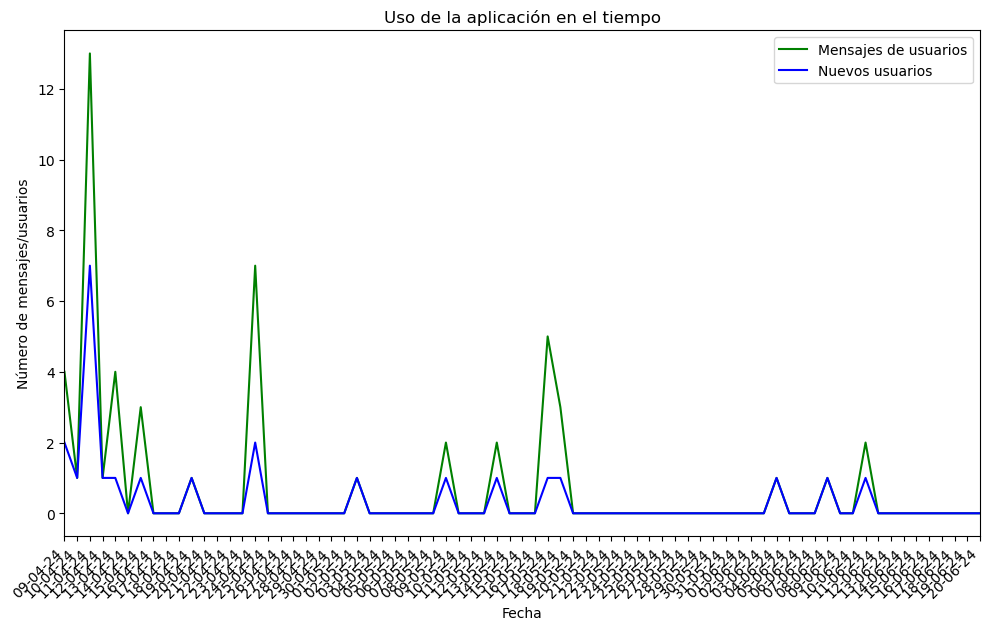

In [8]:
# Se convierte la columna fecha a tipo datetime
processed_data['fecha_creacion'] = pd.to_datetime(processed_data['fecha_creacion'], unit='s')

# Se agrupa por fecha y se cuentan los mensajes de rol user
usage = processed_data[processed_data['rol'] == 'user'].groupby(processed_data['fecha_creacion'].dt.date).size()

# Se cuentan por día los nuevos thread_id
new_users = processed_data[processed_data['rol'] == 'user'].groupby(processed_data['fecha_creacion'].dt.date)['thread_id'].nunique()

# Se crea un DataFrame con todas las fechas desde el inicio hasta la fecha actual
start_date = usage.index.min()
end_date = datetime.now().date()
date_range = pd.date_range(start=start_date, end=end_date, freq='D')
usage_all_dates = usage.reindex(date_range, fill_value=0)
new_users_all_dates = new_users.reindex(date_range, fill_value=0)

# Se grafica el uso de la aplicación en el tiempo
plt.figure(figsize=(10, 6))
usage_all_dates.plot(color='green', label='Mensajes de usuarios')
new_users_all_dates.plot(color='blue', label='Nuevos usuarios')

# Formato de la fecha
ax = plt.gca()  # Obtener el objeto de ejes actual
date_format = mdates.DateFormatter('%d-%m-%y')
ax.xaxis.set_major_formatter(date_format)

# Ajustar la frecuencia de las etiquetas en el eje x
ax.xaxis.set_major_locator(mdates.DayLocator(interval=1))  # Mostrar etiquetas cada 1 día

# Rotación de las etiquetas del eje x
plt.setp(ax.get_xticklabels(), rotation=45, ha='right')

# Ajustar el espaciado para evitar la superposición
plt.tight_layout()

# Título y etiquetas de los ejes
plt.title('Uso de la aplicación en el tiempo')
plt.xlabel('Fecha')
plt.ylabel('Número de mensajes/usuarios')

# Leyenda
plt.legend()

# Mostrar el gráfico
plt.show()